This script gives an example of how to compute gamma ray observable templates given a cluster model.

# Import

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy.wcs import WCS
from minot import model

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

# Define a cluster object

### First define a cluster object, giving already some of the properties here

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/Users/adam/Desktop/test')

                                  _             _                         
                        _ __ ___ (_)_ __   ___ | |_                       
                       | '_ ` _ \| | '_ \ / _ \| __|                      
                       | | | | | | | | | | (_) | |_                       
                       |_| |_| |_|_|_| |_|\___/ \__|                      
Modeling of the ICM (Non-)thermal content and Observables prediction Tools
--------------------------------------------------------------------------
                                                                          
Setting gNFW Planck coll. (2013) UPP.


### Check what are the model parameters

In [3]:
clust.print_param() # To print the parameters in the terminal
clust.save_param()  # To write the parameters in the output directory

--- silent
    False
    <class 'bool'>
--- output_dir
    /Users/adam/Desktop/test
    <class 'str'>
--- cosmo
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
    <class 'astropy.cosmology.core.FlatLambdaCDM'>
--- name
    Coma
    <class 'str'>
--- coord
    <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>
    <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
--- redshift
    0.023
    <class 'float'>
--- D_ang
    98.96826080187294 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- D_lum
    103.57315500872328 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    700000000000000.0 solMass
    <class 'astropy.units.quantity.Quantity'>
--- R500
    1369.4682138780333 kpc
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    0.7928273993781807 deg
    <class 'astropy.units.quantity.Quantity'>
--- R_truncation
    4108.4046416341 kpc
    <class 'astropy.units.quantity.Quantity'>


### You can also change parameters after

In [4]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_crp_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Setting cosmic ray to thermal pressure ratio value


### Check the densities

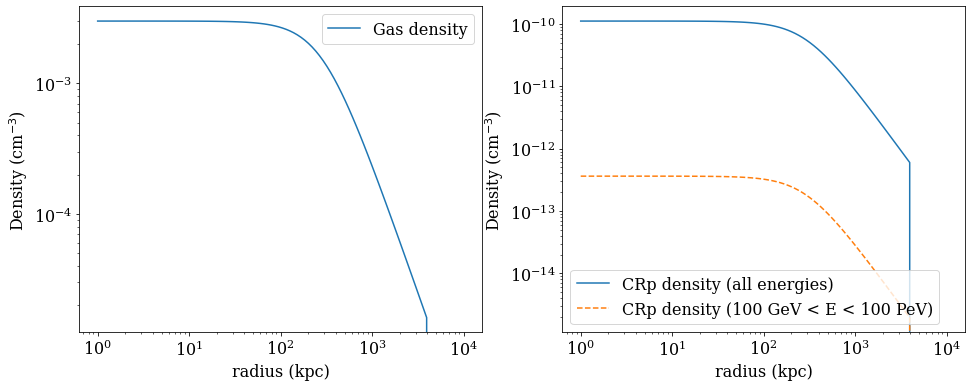

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(121)
r, n_gas_r = clust.get_density_gas_profile()
plt.loglog(r, n_gas_r, label='Gas density')
plt.xlabel('radius (kpc)')
plt.ylabel('Density (cm$^{-3}$)')
plt.legend()

plt.subplot(122)
r, n_crp_r = clust.get_density_crp_profile()
plt.loglog(r, n_crp_r, label='CRp density (all energies)')
r, n_crp_r = clust.get_density_crp_profile(Emin=100*u.GeV, Emax=100*u.PeV)
plt.loglog(r, n_crp_r, '--', label='CRp density (100 GeV < E < 100 PeV)')
plt.xlabel('radius (kpc)')
plt.ylabel('Density (cm$^{-3}$)')
plt.legend()

### Check the CR to thermal energy (thermal energy is derived from pressure profile)

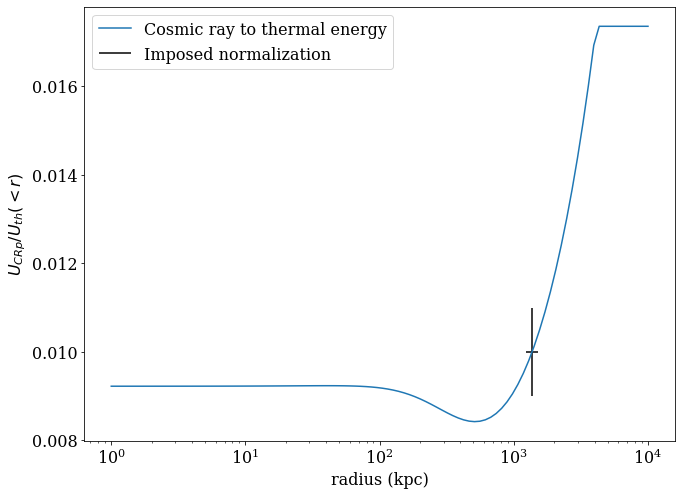

In [6]:
plt.figure(figsize=(10,8))
r, x_r = clust.get_crp_to_thermal_energy_profile(Emin=None, Emax=None)
plt.plot(r, x_r, label='Cosmic ray to thermal energy')
plt.vlines(clust.X_crp_E['R_norm'].to_value('kpc'), clust.X_crp_E['X']*0.9, clust.X_crp_E['X']*1.1, label='Imposed normalization')
plt.hlines(clust.X_crp_E['X'], clust.X_crp_E['R_norm'].to_value('kpc')*0.9, clust.X_crp_E['R_norm'].to_value('kpc')*1.1)
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('$U_{CRp}/U_{th} (<r)$')
plt.legend()

# Extract the surface brightness profile

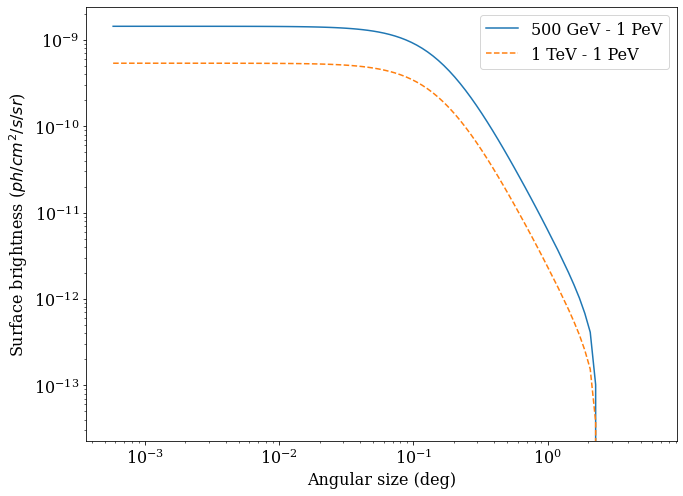

In [7]:
r1, p1 = clust.get_gamma_profile(radius=np.logspace(0,4,100)*u.kpc, 
                                   Emin=500*u.GeV, Emax=1*u.PeV, Energy_density=False)
r2, p2 = clust.get_gamma_profile(radius=np.logspace(0,4,100)*u.kpc, 
                                   Emin=1000*u.GeV, Emax=1*u.PeV, Energy_density=False)
plt.figure(0,figsize=(10,8))
plt.loglog((r1/clust.D_ang*u.rad).to('deg'),p1.to('cm-2 s-1 sr-1'), '-', label='500 GeV - 1 PeV')
plt.loglog((r2/clust.D_ang*u.rad).to('deg'),p2.to('cm-2 s-1 sr-1'), '--', label='1 TeV - 1 PeV')
plt.xlabel('Angular size (deg)')
plt.ylabel('Surface brightness ($ph/cm^2/s/sr$)')
plt.legend()

# Extract the spectrum

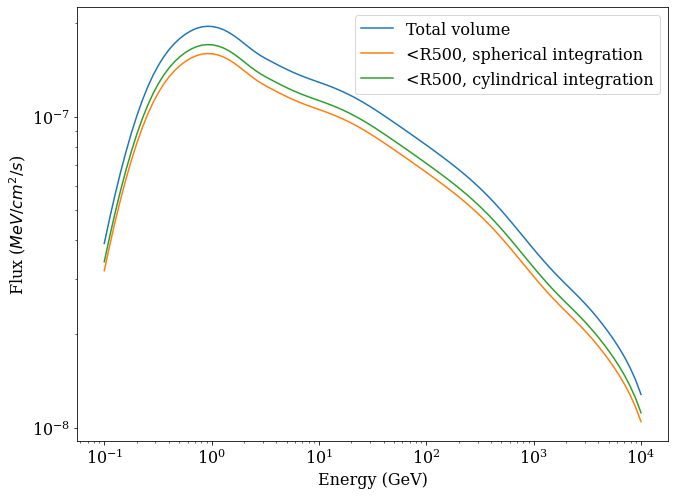

In [8]:
energy = np.logspace(-1,4,100)*u.GeV
e1, s1 = clust.get_gamma_spectrum(energy,Rmax=clust.R_truncation, type_integral='spherical')
e2, s2 = clust.get_gamma_spectrum(energy,Rmax=clust.R500, type_integral='spherical')
e3, s3 = clust.get_gamma_spectrum(energy,Rmax=clust.R500, type_integral='cylindrical')

plt.figure(0,figsize=(10,8))
plt.loglog(e1, (e1**2*s1).to('MeV cm-2 s-1'), '-', label='Total volume')
plt.loglog(e2, (e2**2*s2).to('MeV cm-2 s-1'), '-', label='<R500, spherical integration')
plt.loglog(e3, (e3**2*s3).to('MeV cm-2 s-1'), '-', label='<R500, cylindrical integration')
plt.xlabel('Energy (GeV)')
plt.ylabel('Flux ($MeV/cm^2/s$)')
plt.legend()

# Compute the gamma ray map template

In [9]:
# Defines the grid
clust.map_reso = 0.01*u.deg
clust.map_fov = 5.0*u.deg

# The center of the map can be offset wrt the cluster
clust.map_coord = SkyCoord("194.5d  27.2d", frame="icrs", unit="deg")

# Get the corresponding header
header = clust.get_map_header()

Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map coordinates
Setting: map_header to None, as map properties are now set by hand


### Extract the template

In [10]:
template = clust.get_gamma_map(Emin=None, Emax=None, 
                               Energy_density=False, 
                               Normalize=True) # The map is normalized to the total flux, to be in unit of sr-1

### Check the map

/Users/adam/Project/anaconda3/envs/env37/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  


Text(0.5, 1.0, 'Coma, gamma template ($sr^{-1}$)')

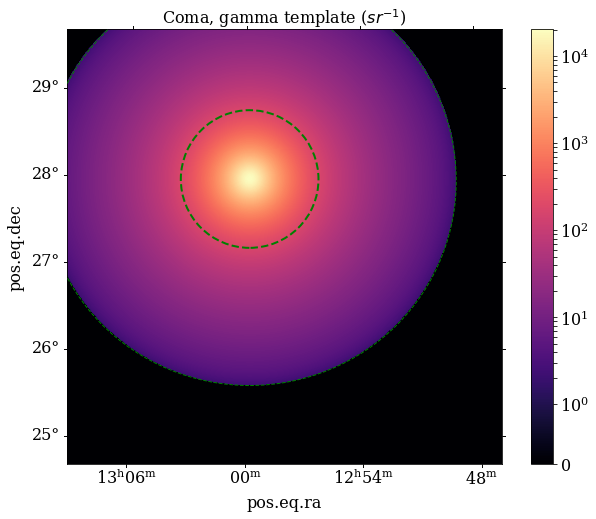

In [11]:
rad500 = clust.theta500.to_value('deg')
radtru = clust.theta_truncation.to_value('deg')

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(template, vmin=0, origin='lower', cmap='magma', norm=SymLogNorm(1))

# Show R500
circle500 = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad500/np.cos(clust.coord.dec.value*np.pi/180), 2*rad500,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
# Show R_truncation
circletru = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*radtru/np.cos(clust.coord.dec.value*np.pi/180), 2*radtru,
                                        linewidth=1, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle500)
ax.add_patch(circletru)
plt.colorbar()
plt.title(clust.name+', gamma template ($sr^{-1}$)')

# Save outputs

In [12]:
# Save the parameters
clust.save_param()

# Save relevant output products
clust.save_spectra()
clust.save_profile()
clust.save_map()

# Can also produce plots
clust.plot(prod_list=['all'])

('Mean temperature used to compute the spectrum:', <Quantity 6.1284062 keV>)


----- Plot done: gas pressure
----- Plot done: gas density
----- Plot done: gas temperature
----- Plot done: gas entropy
----- Plot done: HSE mass
----- Plot done: density contrast
----- Plot done: gas mass
----- Plot done: gas fraction
----- Plot done: thermal energy
----- Plot done: magnetic field
----- Plot done: CRp density
----- Plot done: CRp/thermal energy
----- Plot done: CRe2 density
----- Plot done: CRe1 density
----- Plot done: CRe1/thermal energy
----- Plot done: gamma surface brightness profile
----- Plot done: gamma integrated (R) flux
----- Plot done: neutrino surface brightness profile
----- Plot done: neutrino integrated (R) flux
----- Plot done: IC surface brightness profile
----- Plot done: IC integrated (R) flux
----- Plot done: Synchrotron surface brightness profile
----- Plot done: Synchrotron integrated (R) flux
----- Plot done: SZ Compton
----- Plot done: SZ integrated Compton (spherical)
----- Plot done: Xray surface brightness
----- Plot done: Xray integrated 